In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
from datetime import timedelta
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
c_01 = pd.read_csv("hpq_20230218152055.log", names=["date", "size"])
c_01

,date,size
0,2023-02-18T15:20:56+00:00,14
1,2023-02-18T15:20:57+00:00,14
2,2023-02-18T15:20:59+00:00,14
3,2023-02-18T15:21:00+00:00,14
4,2023-02-18T15:21:01+00:00,14
...,...,...
631,2023-02-18T15:32:38+00:00,14
632,2023-02-18T15:32:40+00:00,14
633,2023-02-18T15:32:41+00:00,14
634,2023-02-18T15:32:42+00:00,14


In [3]:
def parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [4]:
def fuzzy_loop(ser: List[float], batch_size=50) -> List[float]:
    return [nk.entropy_fuzzy(np.array(ser[index - batch_size:index]))[0] for index in range(len(ser))[batch_size:]]


def dist_loop(ser: List[float], batch_size=50) -> List[float]:
    return [nk.entropy_distribution(np.array(ser[index - batch_size:index]))[0] for index in
            range(len(ser))[batch_size:]]


def ap_loop(ser: List[float], batch_size=50) -> List[float]:
    return [nk.entropy_approximate(np.array(ser[index - batch_size:index]))[0] for index in
            range(len(ser))[batch_size:]]

In [5]:
eda_signal = nk.eda_simulate(duration=10, sampling_rate=250, scr_number=3, drift=0.01)

In [6]:
eda_signal

array([0.99724718, 0.99729309, 0.99734945, ..., 1.19610025, 1.19583347,
       1.19559079])

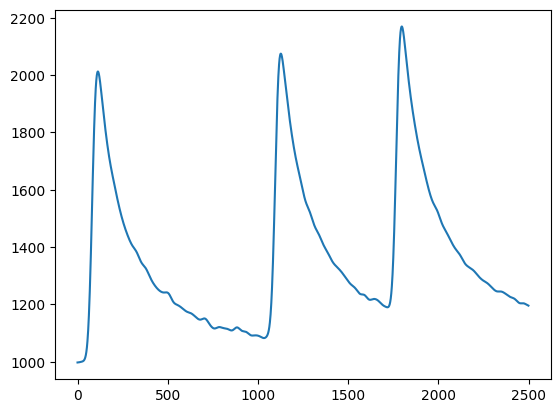

In [13]:
plt.plot(eda_signal*1000)

In [29]:
fuzzy_01 = fuzzy_loop(eda_signal, batch_size=100)

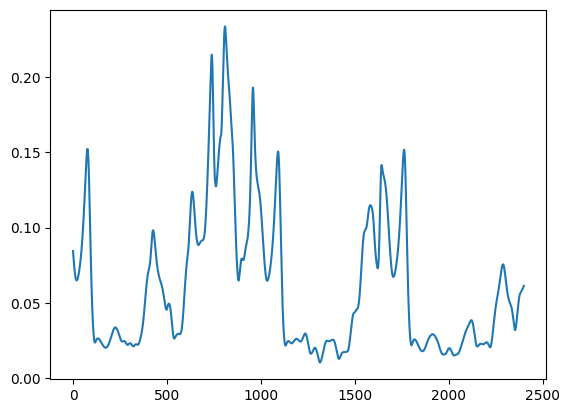

In [30]:
plt.plot(fuzzy_01)

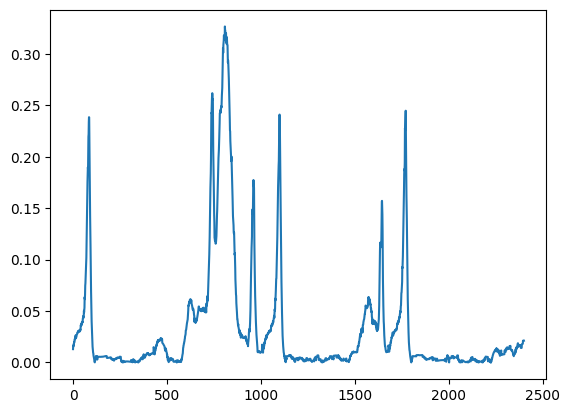

In [28]:
ap_01 = ap_loop(eda_signal, batch_size=100)
plt.plot(ap_01)

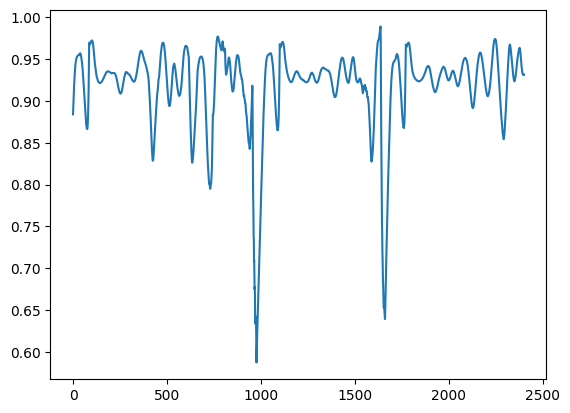

In [31]:
dist_01 = dist_loop(eda_signal, batch_size=100)
plt.plot(dist_01)

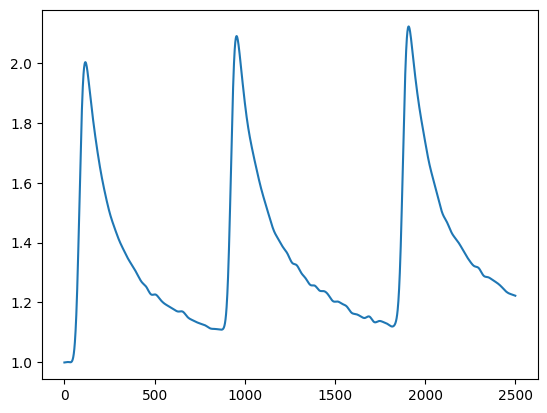

In [42]:
eda_signal_01 = nk.eda_simulate(duration=10, sampling_rate=250, scr_number=3, drift=0.01)
plt.plot(eda_signal_01)

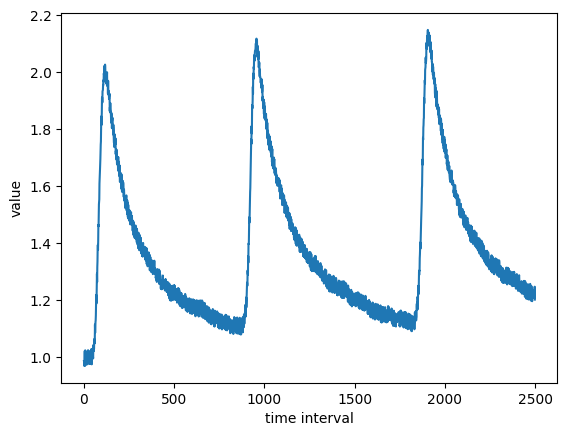

In [65]:
import random
eda_signal_01_randomized = [x + random.uniform(-0.03, 0.03) for x in eda_signal_01]
plt.plot(eda_signal_01_randomized)
plt.xlabel(xlabel="time interval")
plt.ylabel(ylabel="value")
plt.savefig("eda_signal_01_randomized.png")

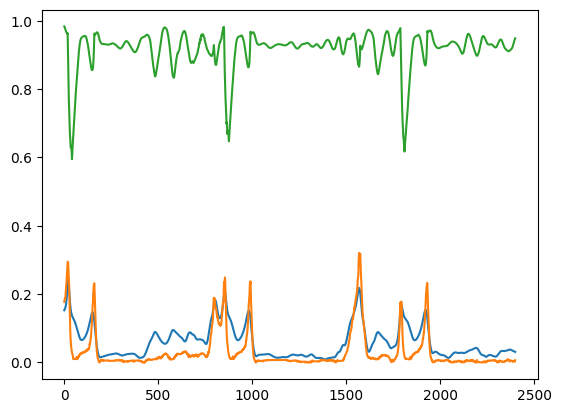

In [35]:
fuzzy_01 = fuzzy_loop(eda_signal_01, batch_size=100)
plt.plot(fuzzy_01)
ap_01 = ap_loop(eda_signal_01, batch_size=100)
plt.plot(ap_01)
dist_01 = dist_loop(eda_signal_01, batch_size=100)
plt.plot(dist_01)

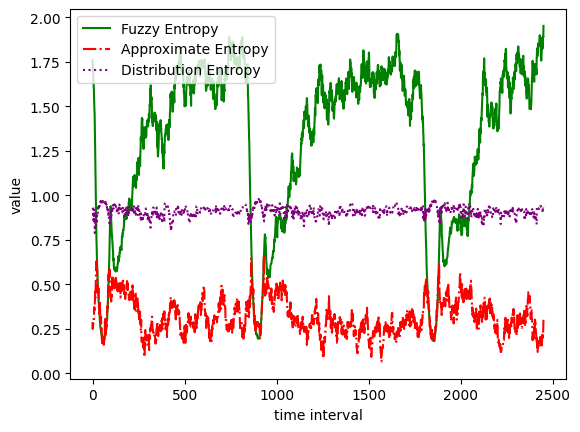

In [78]:
fuzzy_01_randomized = fuzzy_loop(eda_signal_01_randomized, batch_size=50)
plt.plot(fuzzy_01_randomized, color="green", label='Fuzzy Entropy')
ap_01_randomized = ap_loop(eda_signal_01_randomized, batch_size=50)
plt.plot(ap_01_randomized, color="red", linestyle='dashdot', label='Approximate Entropy')
dist_01_randomized = dist_loop(eda_signal_01_randomized, batch_size=50)
plt.plot(dist_01_randomized, color="purple", linestyle='dotted', label='Distribution Entropy')
plt.xlabel(xlabel="time interval")
plt.ylabel(ylabel="value")
plt.legend()
plt.savefig("entropy_eda_signal_01_randomized.png")

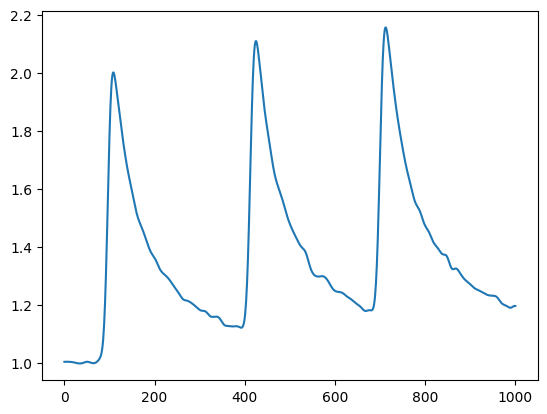

In [45]:
eda_signal_02 = nk.eda_simulate(duration=10, sampling_rate=100, scr_number=3, drift=0.01)
plt.plot(eda_signal_02)

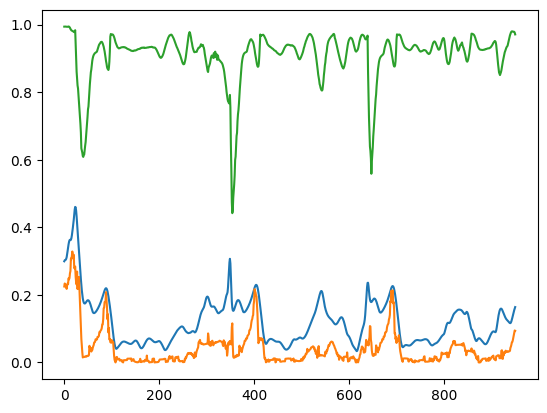

In [47]:
fuzzy_02 = fuzzy_loop(eda_signal_02, batch_size=50)
plt.plot(fuzzy_02)
ap_02 = ap_loop(eda_signal_02, batch_size=50)
plt.plot(ap_02)
dist_02 = dist_loop(eda_signal_02, batch_size=50)
plt.plot(dist_02)

In [48]:
eog_signal = nk.data('eog_100hz.csv')

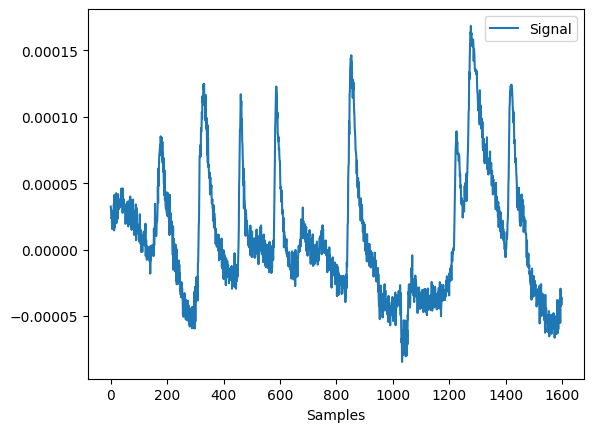

In [49]:
nk.signal_plot(eog_signal[100:1700])

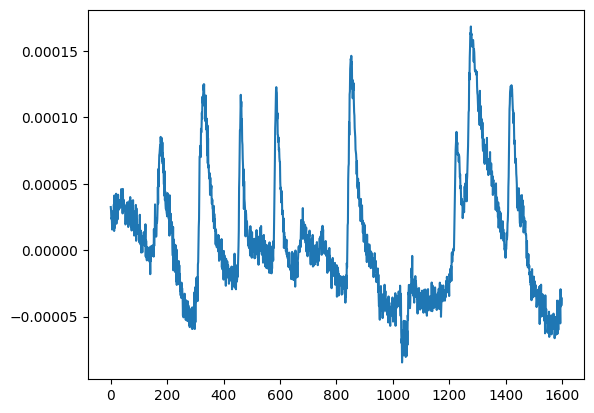

In [50]:
plt.plot(eog_signal[100:1700])

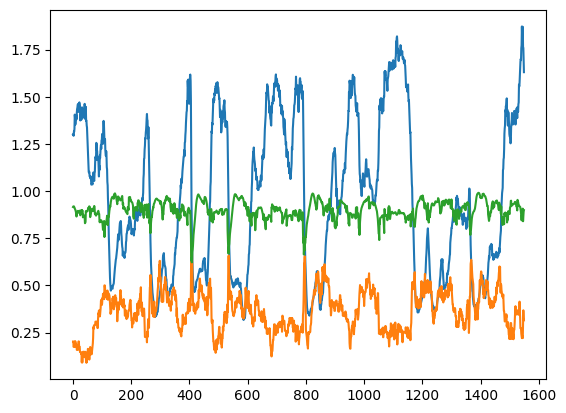

In [51]:
fuzzy_03 = fuzzy_loop(eog_signal[100:1700], batch_size=50)
plt.plot(fuzzy_03)
ap_03 = ap_loop(eog_signal[100:1700], batch_size=50)
plt.plot(ap_03)
dist_03 = dist_loop(eog_signal[100:1700], batch_size=50)
plt.plot(dist_03)

In [67]:
# Retrieve ECG data from data folder
ecg_signal = nk.data(dataset="ecg_1000hz")
# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=1000)

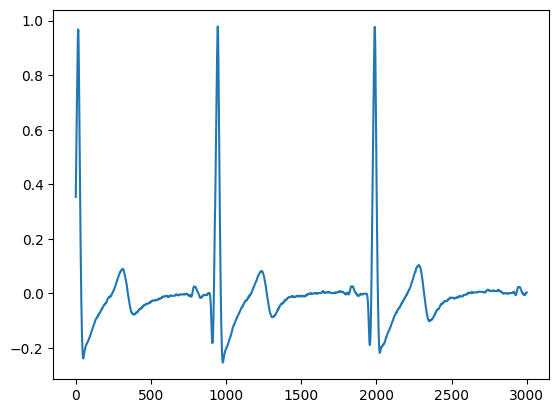

In [71]:
plt.plot(ecg_signal[:3000])

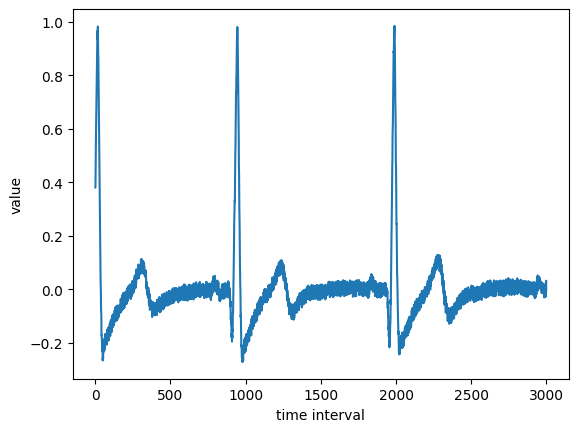

In [75]:
ecg_randomized = [x + random.uniform(-0.03, 0.03)for x in ecg_signal[:3000]]
plt.xlabel(xlabel="time interval")
plt.ylabel(ylabel="value")
plt.plot(ecg_randomized)
plt.savefig("ecg_signal_01_randomized.png")

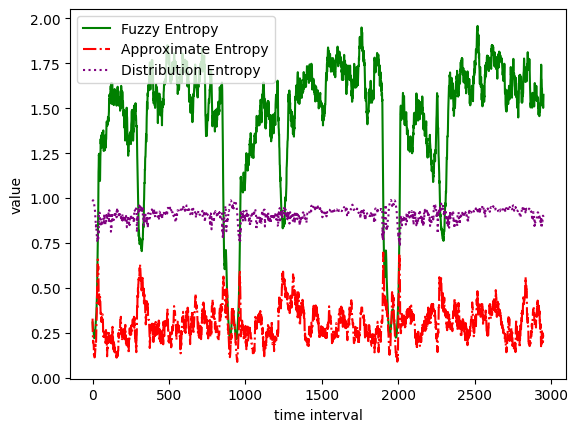

In [79]:
fuzzy_ecg_randomized = fuzzy_loop(ecg_randomized, batch_size=50)
plt.plot(fuzzy_ecg_randomized, color="green", label='Fuzzy Entropy')
ap_ecg_randomized = ap_loop(ecg_randomized, batch_size=50)
plt.plot(ap_ecg_randomized, color="red", linestyle='dashdot', label='Approximate Entropy')
dist_ecg_randomized = dist_loop(ecg_randomized, batch_size=50)
plt.plot(dist_ecg_randomized, color="purple", linestyle='dotted', label='Distribution Entropy')
plt.xlabel(xlabel="time interval")
plt.ylabel(ylabel="value")
plt.legend()
plt.savefig("entropy_ecg_signal_01_randomized.png")